In [2]:
import os
import tarfile
import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    os.makedirs(housing_path, exist_ok=True)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [3]:
fetch_housing_data()

In [4]:
# Loading data using pandas
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [5]:
housing = load_housing_data()
#housing.dropna(inplace = True)
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [6]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [7]:
housing["ocean_proximity"].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

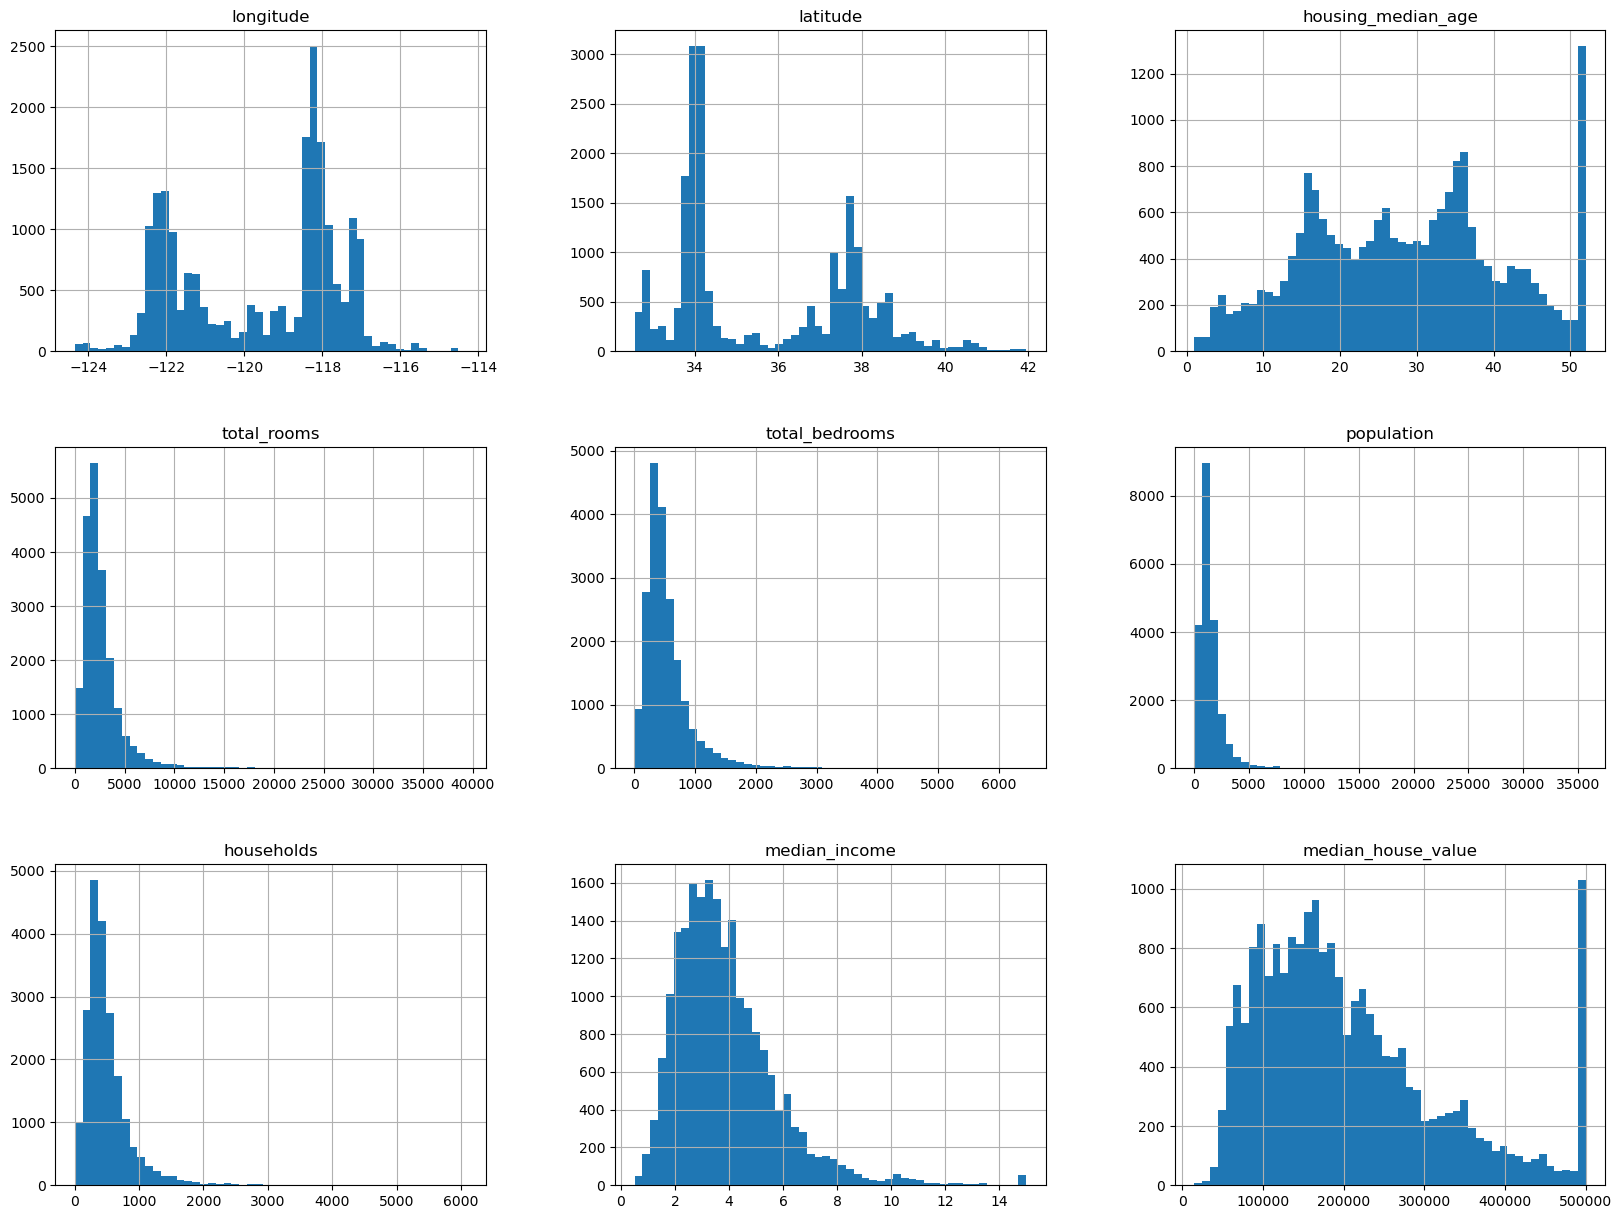

In [8]:
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20, 15))
plt.show()

In [9]:
import numpy as np
#housing.dropna(subset=["total_bedrooms"]) # removed the empty data
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [10]:
train_set, test_set = split_train_test(housing, 0.2)
print(len(test_set))
len(train_set)

4128


16512

In [11]:
from zlib import crc32

def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [12]:
housing_with_id = housing.reset_index()
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")

In [13]:
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")

In [14]:
# to use Scikit-Learn's function to generate randomness in the instances\
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

<Axes: >

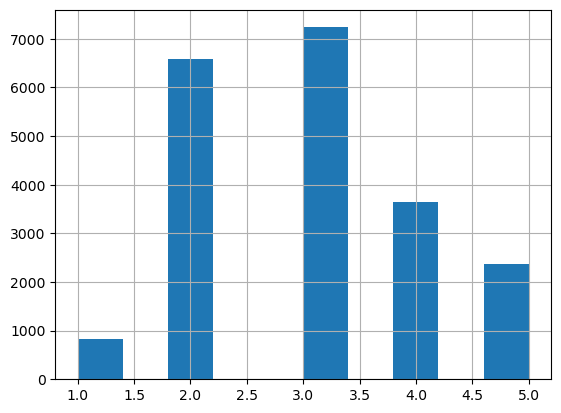

In [15]:
housing["income_cat"] = pd.cut(housing["median_income"], bins=[0., 1.5, 3.0, 4.5, 6., np.inf], labels=[1, 2, 3, 4, 5])
housing["income_cat"].hist()

In [16]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [17]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

income_cat
3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: count, dtype: float64

In [18]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis = 1,inplace = True)

<Axes: xlabel='longitude', ylabel='latitude'>

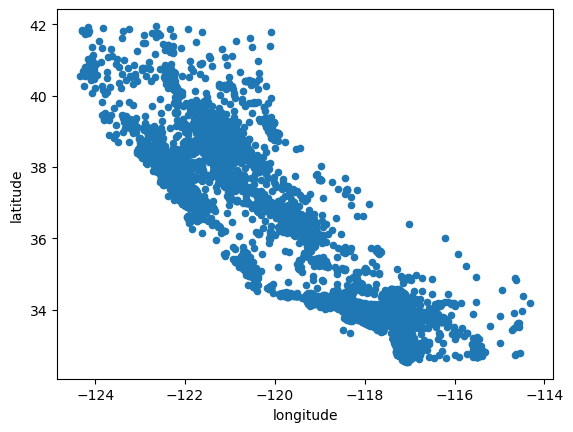

In [19]:
# Visualizing geographical data
strat_train_set.dropna(inplace = True)
housing  = strat_train_set.copy()
housing.plot(kind="scatter", x="longitude", y = "latitude")

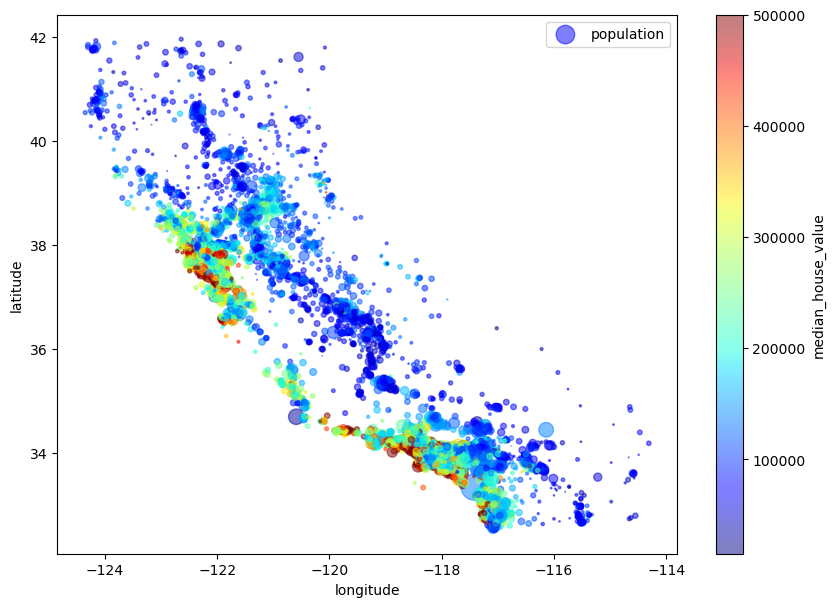

In [20]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.5, s=housing["population"]/100, label="population", figsize=(10, 7), c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,)
plt.legend()

In [21]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_new = housing.drop("ocean_proximity", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

Training the model

In [23]:
housing_new.dropna(inplace = True)
print(type(housing_new))
housing_new[housing_new.total_bedrooms.isnull()]

<class 'pandas.core.frame.DataFrame'>


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income


Linear Regression

In [24]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_new, housing_labels)

LinearRegression()

In [25]:
some_data = housing_new.iloc[:5]
some_labels = housing_labels.iloc[:5]
print("Predictions:", lin_reg.predict(some_data))
print("Labels:", list(some_labels))

Predictions: [ 95686.92924449 293017.17399033 175408.47983955 176873.45777285
 243563.5135992 ]
Labels: [72100.0, 279600.0, 82700.0, 112500.0, 238300.0]


In [26]:
from sklearn.metrics import mean_squared_error
housing_predictions = lin_reg.predict(housing_new)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

69860.00486632237

DecisionTree Regressor

In [27]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_new, housing_labels)

DecisionTreeRegressor()

In [28]:
housing_predictions = tree_reg.predict(housing_new)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

Cross Validation

In [29]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(tree_reg, housing_new, housing_labels, scoring = "neg_mean_squared_error", cv = 10)
tree_rmse_scores = np.sqrt(-scores)

In [30]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)

Scores: [72241.0698471  70843.61745528 69721.81239846 76020.29852577
 69924.28015115 72667.60829354 74461.44572524 67208.30936803
 69221.77990526 74457.62898076]
Mean: 71676.78506505741
Standard deviation: 2631.2614902455925


In [31]:
lin_scores = cross_val_score(lin_reg, housing_new, housing_labels, scoring="neg_mean_squared_error", cv = 10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [72618.41418433 66189.28483037 68288.69757036 69744.21101012
 67550.51534057 74057.71419029 71961.1448439  70424.530212
 67682.68279767 71386.83568966]
Mean: 69990.40306692784
Standard deviation: 2411.541265237254


SVM Regressor

In [32]:
from sklearn.svm import LinearSVR
svm_reg = LinearSVR(epsilon = 1.5)
svm_reg.fit(housing_new, housing_labels)

C:\Users\Yashraj\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVR(epsilon=1.5)

In [33]:
SVR_scores = cross_val_score(svm_reg, housing_new, housing_labels, scoring="neg_mean_squared_error", cv=20)
SVR_rmse_scores = np.sqrt(-SVR_scores)
display_scores(SVR_rmse_scores)

C:\Users\Yashraj\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Yashraj\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Yashraj\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Yashraj\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Yashraj\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Yashraj\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase

Scores: [ 92647.98320448  97777.02545131  94174.5016062   94486.25382243
  97272.46452705  87312.79136899  98440.56651598  97093.25900553
  90919.12864422  94434.239292    95923.45472818 100788.46943026
  96537.17957833  97692.51657139  97613.36379148  93664.36561877
  97107.64086206  95876.79301787  95651.4396652   95327.08506258]
Mean: 95537.02608821625
Standard deviation: 2865.3007869448766


C:\Users\Yashraj\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
